# CIFAR VeriSeti

In [1]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'X_train boyutu = {X_train.shape}')
print(f'y_train boyutu = {y_train.shape}')
print('---------------------------------------')
print(f'X_test boyutu = {X_test.shape}')
print(f'y_test boyutu = {y_test.shape}')

X_train boyutu = (50000, 32, 32, 3)
y_train boyutu = (50000, 1)
---------------------------------------
X_test boyutu = (10000, 32, 32, 3)
y_test boyutu = (10000, 1)


<Figure size 432x288 with 0 Axes>

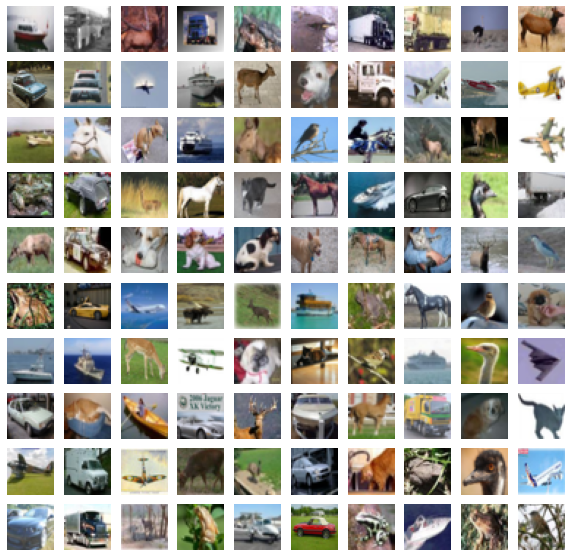

In [2]:
# random image representation

import numpy as np
import matplotlib.pyplot as plt

ROWS = 10

X = X_train.astype('uint8')

plt.clf()

fig, axes = plt.subplots(ROWS, ROWS, figsize=(10, 10))

for i in range(ROWS):
    for j in range(ROWS):
        rnd = np.random.choice(range(len(X)))
        axes[i][j].set_axis_off()
        axes[i][j].imshow(X[rnd:rnd+1][0])

# Varolan Veriseti ile CNN

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.fit(training_set,
                         batch_size = 128,
                         epochs = 25,
                         validation_data = test_set)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/25
250/250 [==============================] - 38s 154ms/step - loss: 0.6729 - accuracy: 0.5738 - val_loss: 0.6193 - val_accuracy: 0.6725
Epoch 2/25
250/250 [==============================] - 39s 155ms/step - loss: 0.6262 - accuracy: 0.6492 - val_loss: 0.6011 - val_accuracy: 0.6835
Epoch 3/25
250/250 [==============================] - 40s 160ms/step - loss: 0.5870 - accuracy: 0.6830 - val_loss: 0.5529 - val_accuracy: 0.7245
Epoch 4/25
250/250 [==============================] - 40s 162ms/step - loss: 0.5622 - accuracy: 0.7107 - val_loss: 0.5459 - val_accuracy: 0.7320
Epoch 5/25
250/250 [==============================] - 38s 154ms/step - loss: 0.5439 - accuracy: 0.7184 - val_loss: 0.6073 - val_accuracy: 0.6840
Epoch 6/25
250/250 [==============================] - 39s 156ms/step - loss: 0.5200 - accuracy: 0.7369 - val_loss: 0.5881 - val_accuracy: 0.7115
Epoch 7/25
250/250 [==========================

In [8]:
score = classifier.evaluate(test_set, verbose=0)
print(f'Test Loss = {score[0]}')
print(f'Test Accuracy = {score[1]}')


Test Loss = 0.5854012370109558
Test Accuracy = 0.7754999995231628


In [11]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img('dataset/single_prediction/cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
print(training_set.class_indices)
if result[0][0] == 1:
    print('prediction = dog')
else:
    print('prediction = cat')

{'cats': 0, 'dogs': 1}
prediction = dog


# Darknet ile Birden Fazla Görüntüyü Tanıma

Programcılar tipik olarak bir görüntünün merkezinde bulunan tek bir öğeyi sınıflandırmak için evrişimli sinir ağları tasarlarlar, ancak insanlar olarak görüş alanımızdaki birçok öğeyi gerçek zamanlı olarak tanıyabiliriz. Tek bir görüntüde birden çok öğeyi tanımak avantajlıdır. Bunu yapmanın en gelişmiş yollarından biri YOLODarkNet'tir. YOLO,  bir kısaltmadır. YOLO, görüntünün üzerinde bir tarama gerçekleştirmek anlamına gelir. YOLO'yu canlı video akışlarında çalıştırmak da mümkündür. </br>

<img src='yolo1.png'/>
<center>Yolo ile Etiketleme(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

## YOLO Nasıl Çalışır?

YOLO, görüntüyü bir S × S boyutundaki gridde yeniden boyutlandırarak başlar. YOLO, bu gride karşı, sınırlayıcı kutuları ve bu kutularda neler olabileceğini tahmin eden tek bir evrişimli sinir ağı çalıştırır. Her sınırlayıcı kutu, kutunun içerdiğine inandığı öğeye de güvenir. YOLO, normal bir evrişim ağıdır. Tek fark, bir YOLO CNN'nin birden fazla tahmin sınırlayıcı kutu vermesidir.</br>

<img src='yolo2.png'/>
<center>Yolo Tespit Sistemi(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

YOLO evrişimli sinir ağlarının çıktısı esasen bir çoklu regresyondur. YOLO, sınırlayıcı dikdörtgenlerin her biri için aşağıdaki değerleri üretir.</br>

<li><b>x :</b> Sınırlayıcı bir dikdörtgenin merkezinin x koordinatı</li>
<li><b>y :</b> Sınırlayıcı bir dikdörtgenin merkezinin y koordinatı</li>
<li><b>w :</b> Her sınırlayıcı dikdörtgenin genişliği</li>
<li><b>h :</b> Her sınırlayıcı dikdörtgenin yüksekliği</li>
<li><b>labels :</b> Her bir etiketin göreli olasılıkları (her etiket için 1 değer)</li>
<li><b>confidence :</b> Bu dikdörtgene olan güven değeri</li>

Bir Keras sinir ağının çıktı katmanı bir Tensördür. Bu durumda YOLOçıkış tensörü 3B'dir ve aşağıdaki boyutlardadır. </br>

<i>S×S×(B·5 +C)</i></br>

<li><b>S :</b> YOLO'nun kaynak görüntüyü kapladığı boyutlar</li>
<li><b>B :</b> Her ızgara hücresi için oluşturulan potansiyel sınırlayıcı dikdörtgenlerin sayısı</li>
<li><b>C :</b> Sınıf etiketlerinin sayısı.</li>

Yukarıdaki ifadedeki 5 değeri, basitçe her bir sınırlayıcı dikdörtgenin (x, y, h, w, confidence) etiketsiz bileşenlerinin sayısıdır.

<img src='yolo3.png'/>
<center>Yolo Mimarisi(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

# YOLO Uygulaması

YoloV3-TF2 kitaplığı, Python uygulamalarıyla kolayca entegre edilebilir. Kütüphanenin başlatılması üç adımdan oluşur. İlk olarak, kütüphane için gerekli tüm paketler import edilir. Daha sonra, Python programı Keras bayrak mimarisi aracılığıyla tüm YOLO konfigürasyonlarını tanımlamalıdır. Keras bayrak sistemi öncelikle komut satırından çalışır; ancak, bir uygulamada programlı olarak yapılandırmaya da izin verir.  Son olarak, uygulamanın herhangi bir GPU'dan yararlanabilmesi için mevcut cihazlar taranmalıdır. 

In [7]:
# conda create -n yolo python=3.7 notebook
# conda activate yolo
# conda install -c anaconda tensorflow-gpu
# https://github.com/zzh8829/yolov3-tf2
# ! pip install git+https://github.com/zzh8829/yolov3-tf2.git

  Cloning https://github.com/zzh8829/yolov3-tf2.git to /tmp/pip-req-build-p6xx3moc
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-p6xx3moc
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-py3-none-any.whl size=9128 sha256=b6d5f842597d1264285df78d877840277ad62f0332aaa37b48f6cb1fb00c460c
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3c5rjjf/wheels/3f/73/07/bc746f289c6b419918dcb7e86824547be43fcdd36ad2d2561d
Successfully built yolov3-tf2


In [24]:
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)

ModuleNotFoundError: No module named 'yolov3_tf2.models'